In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
def getFields():
    tfiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.sea.surface.temperature.0.75.x.0.75.1979-2018.nc'
    vfiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.v.*.nc'

    print("READING Z")
    
    zfiles1='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.geoheight.19*.nc'
    zfiles2='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.geoheight.2000s.nc'
    zfiles3='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.geoheight.2010s.nc'
    zfiles4='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.geoheight.2019s.nc'

    # Z500 and Z850
    ds_z1=xr.open_mfdataset(zfiles1,combine='by_coords').sel(level=slice(100,1000))
    ds_z2=xr.open_dataset(zfiles2).sel(level=slice(100,1000))
    ds_z3=xr.open_dataset(zfiles3).sel(level=slice(100,1000))
    ds_z4=xr.open_dataset(zfiles4)
    ds_z=xr.combine_by_coords([ds_z1,ds_z2,ds_z3,ds_z4])
    ds_z500=ds_z.sel(level=500).rename({'z':'z500'})
    ds_z850=ds_z.sel(level=850).rename({'z':'z850'})
    print(ds_z500)
    
    print("READING U")
    # U200 and U850
    
    ufiles1='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.u.19*.nc'
    ufiles2='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.u.2000s.nc'
    ufiles3='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.u.2010s.nc'
    ufiles4='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.u.2019s.nc'

    ds_u1=xr.open_mfdataset(ufiles1,combine='by_coords').sel(level=slice(100,1000))
    ds_u2=xr.open_dataset(ufiles2).sel(level=slice(100,1000))
    ds_u3=xr.open_dataset(ufiles3).sel(level=slice(100,1000))
    ds_u4=xr.open_dataset(ufiles4)
    ds_u=xr.combine_by_coords([ds_u1,ds_u2,ds_u3,ds_u4],combine_attrs='override')

    ds_u200=ds_u.sel(level=200).rename({'u':'u200'})
    ds_u850=ds_u.sel(level=850).rename({'u':'u850'})

    print("READING V")
    # V200 and V850
    vfiles1='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.v.19*.nc'
    vfiles2='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.v.2000s.nc'
    vfiles3='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.v.2010s.nc'
    vfiles4='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.v.2019s.nc'

    ds_v1=xr.open_mfdataset(vfiles1,combine='by_coords').sel(level=slice(100,1000))
    ds_v2=xr.open_dataset(vfiles2).sel(level=slice(100,1000))
    ds_v3=xr.open_dataset(vfiles3).sel(level=slice(100,1000))
    ds_v4=xr.open_dataset(vfiles4)
    ds_v=xr.combine_by_coords([ds_v1,ds_v2,ds_v3,ds_v4],combine_attrs='override')

    ds_v200=ds_v.sel(level=200).rename({'v':'v200'})
    ds_v850=ds_v.sel(level=850).rename({'v':'v850'})

    print("READING SST")
    # SST
    tfile1='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.sea.surface.temperature.0.75.x.0.75.1979-2018.nc'
    tfile2='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.sea.surface.temperature.0.75.x.0.75.2019s.nc'

    ds_sst1=xr.open_dataset(tfile1)
    ds_sst2=xr.open_dataset(tfile2)
    ds_sst2=ds_sst2.sel(time=slice('2019-01-01','2019-09-01'))
    ds_sst=xr.combine_by_coords([ds_sst1,ds_sst2],combine_attrs='override')
    ds_sst=ds_sst.sel(time=ds_sst['time.hour']==0)

    print("READING OLR")
    # OLR
    olrfiles1='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.top.net.thermal.radiation.19*s.nc'
    olrfiles2='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.top.net.thermal.radiation.20*s.nc'
    ds_olr1=xr.open_mfdataset(olrfiles1,combine='by_coords',combine_attrs='drop_conflicts',chunks={'time':-1})
    ds_olr1['time']=ds_olr1['time'].dt.floor('d')
    ds_olr2=xr.open_mfdataset(olrfiles2,combine='by_coords',chunks={'time':-1})
    ds_olr=xr.combine_by_coords([ds_olr1,ds_olr2],combine_attrs='drop_conflicts').rename({'ttr':'olr'})
    ds_olr['olr']=ds_olr['olr']*-1
    
    print("COARSE GRAIN")
    # Coarse Grain Data
    new_lon=np.arange(0,360,5)
    new_lat=np.arange(-90,92,5)

    ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                         'lon': (['lon'], new_lon)})
    
    regridder = xe.Regridder(ds_z500,ds_out,'bilinear',periodic=True)
    ds_z500=regridder(ds_z500.chunk({'lon':-1}))
    ds_z850=regridder(ds_z850.chunk({'lon':-1}))
    ds_olr=regridder(ds_olr.chunk({'lon':-1}))
    ds_u200=regridder(ds_u200.chunk({'lon':-1}))
    ds_u850=regridder(ds_u850.chunk({'lon':-1}))
    ds_v200=regridder(ds_v200.chunk({'lon':-1}))
    ds_v850=regridder(ds_v850.chunk({'lon':-1}))

    regridder_sst = xe.Regridder(ds_sst,ds_out,'bilinear',periodic=True)
    ds_sst=regridder_sst(ds_sst)
    
    print("MERGE")
    ds=xr.merge([ds_sst,ds_z500,ds_z850,ds_olr,ds_u850,ds_v850,ds_u200,ds_v200],compat='override')
     
    print("ANOMS")
    ds_anoms=ds.groupby('time.dayofyear')-ds.groupby('time.dayofyear').mean()
    
    return ds_anoms

In [3]:
confidence_thresh=0.80
#r='lrp.alpha_1_beta_0'
mean_dims=['time','model']
target_dataset='era5-precip'
#target_dataset='era-interim-precip'

#### Get data for composites

In [4]:
ds_anoms=getFields()
ds_anoms

READING Z


KeyboardInterrupt: 

### Calculate Composites of LRP and Anomalies (Combine Train-Val,Test)

#for seas in ['DJF','JJA']: 
for seas in ['JJA']: 

    print(seas)
    ds_list=[]
    
    # Combine Train-Val and Test Data
    for tt in ['Train-Val','Test']:
        fname='../data/cnn/'+target_dataset+'/validate/model_validate.'+tt+'.'+seas+'.cnn_cat.*.nc'
        ds=xr.open_mfdataset(fname,combine='nested',concat_dim='model')
        ds_list.append(ds)
    ds_cnn_val=xr.combine_by_coords(ds_list) #.sel(rules=r).drop(['rules'])


ds_list

fname

In [13]:
for seas in ['DJF','JJA']: 
#for seas in ['DJF']: 

    print(seas)
    ds_list=[]
    
    # Combine Train-Val and Test Data
    for tt in ['Train-Val','Test']:
        fname='../data/cnn/'+target_dataset+'/validate/model_validate.'+tt+'.'+seas+'.cnn_cat.*.nc'
        ds=xr.open_mfdataset(fname,combine='nested',concat_dim='model')
        ds_list.append(ds)
    ds_cnn_val=xr.combine_by_coords(ds_list) 

    # Composite LRP
    print("Calculating Composite LRP")
    tmp1=ds_cnn_val.where(np.logical_and(ds_cnn_val['pred']==ds_cnn_val['verif'],
                                        ds_cnn_val['probs']>=confidence_thresh))
    tmp1.chunk({'time':10,'model':10,'cat':2,'lat':37,'lon':72})
    ds_lrp=tmp1.sel(model=0).mean(dim=['time']).compute()
    
    print("Writing LRP Data")
    ds_lrp.to_netcdf('../data/cnn/'+target_dataset+'/xai/model_lrpcomp.'+seas+'.cnn_cat.nc')

DJF
Calculating Composite LRP
Writing LRP Data


In [14]:
for seas in ['DJF','JJA']: 
#for seas in ['DJF']: 

    print(seas)
    ds_list=[]
    
    # Combine Train-Val and Test Data
    for tt in ['Train-Val','Test']:
        fname='../data/cnn/'+target_dataset+'/validate/model_validate.'+tt+'.'+seas+'.cnn_cat.*.nc'
        ds=xr.open_mfdataset(fname,combine='nested',concat_dim='model')
        ds_list.append(ds)
    ds_cnn_val=xr.combine_by_coords(ds_list)
        
    # Composite Fields
    ds_comp_vars=[]
    for v in list(ds_anoms.keys()):
        print(v)
        tmp2=ds_anoms[v].where(np.logical_and(ds_cnn_val['pred']==ds_cnn_val['verif'],
                                              ds_cnn_val['probs']>=confidence_thresh))
        
        tmp3=tmp2.mean(dim=['time','model'],skipna=True).compute()
        
        del tmp2
        
        ds_comp_vars.append(tmp3.to_dataset(name=v))
        
    print("Merging composites")
    ds_comp=xr.merge(ds_comp_vars)
    
    del ds_comp_vars
    
    print("Writing Comp Data")
    ds_comp.to_netcdf('../data/cnn/'+target_dataset+'/xai/model_anomscomp.'+seas+'.cnn_cat.nc')

DJF
sst
z500
z850
olr
u850
v850
u200
v200
Merging composites
Writing Comp Data


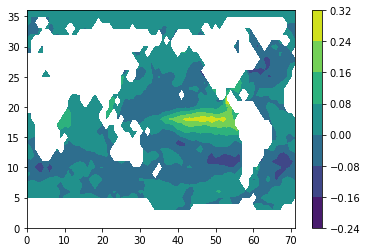

In [15]:
plt.contourf(ds_comp['sst'].sel(cat='Positive'))
plt.colorbar()

In [12]:
for seas in ['DJF','JJA']: 
#for seas in ['DJF']: 

    print(seas)
    ds_list=[]
    
    # Combine Train-Val and Test Data
    for tt in ['Train-Val','Test']:
        fname='../data/cnn/'+target_dataset+'/validate/model_validate.'+tt+'.'+seas+'.cnn_cat.*.nc'
        ds=xr.open_mfdataset(fname,combine='nested',concat_dim='model')
        ds_list.append(ds)
    ds_cnn_val=xr.combine_by_coords(ds_list)

    # Composite LRP
    tmp1=ds_cnn_val.where(np.logical_and(ds_cnn_val['pred']==ds_cnn_val['verif'],
                                        ds_cnn_val['probs']>=confidence_thresh))
    
    # Count number of True, Confident, Positive and Negative
    pos_count=np.count_nonzero(~np.isnan(tmp1['pred'].sel(cat='Positive')))
    neg_count=np.count_nonzero(~np.isnan(tmp1['pred'].sel(cat='Negative')))

    print("True, Confident(>=80), Positive: ",pos_count)
    print("True, Confident(>=80), Negative: ",neg_count)


DJF
True, Confident(>=80), Positive:  46989
True, Confident(>=80), Negative:  68679
JJA
True, Confident(>=80), Positive:  2005
True, Confident(>=80), Negative:  1446


In [17]:
ds_cnn_val

<xarray.Dataset>
Dimensions:  (rules: 2, time: 3669, lat: 37, lon: 72, var: 6, model: 100, cat: 2)
Coordinates:
  * rules    (rules) object 'lrp.alpha_1_beta_0' 'lrp.z'
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-02-28
  * lat      (lat) int64 -90 -85 -80 -75 -70 -65 -60 ... 60 65 70 75 80 85 90
  * lon      (lon) int64 0 5 10 15 20 25 30 35 ... 325 330 335 340 345 350 355
  * var      (var) object 'z500' 'z850' 'u200' 'u850' 'olr' 'sst'
  * cat      (cat) object 'Negative' 'Positive'
  * model    (model) int64 0 1 10 11 12 13 14 15 16 ... 92 93 94 95 96 97 98 99
Data variables:
    lrp      (model, rules, time, lat, lon, var) float32 dask.array<chunksize=(1, 2, 3430, 37, 72, 6), meta=np.ndarray>
    pred     (model, time) int64 dask.array<chunksize=(1, 3430), meta=np.ndarray>
    verif    (model, time) int64 dask.array<chunksize=(1, 3430), meta=np.ndarray>
    probs    (model, time, cat) float32 dask.array<chunksize=(1, 3430, 2), meta=np.ndarray>
    acc      (time, model) float64 dask.array<chunksize=(3430, 1), meta=np.ndarray>

In [18]:
ds_lrp

<xarray.Dataset>
Dimensions:  (rules: 2, lat: 37, lon: 72, var: 6, cat: 2)
Coordinates:
  * rules    (rules) object 'lrp.alpha_1_beta_0' 'lrp.z'
  * lat      (lat) int64 -90 -85 -80 -75 -70 -65 -60 ... 60 65 70 75 80 85 90
  * lon      (lon) int64 0 5 10 15 20 25 30 35 ... 325 330 335 340 345 350 355
  * var      (var) object 'z500' 'z850' 'u200' 'u850' 'olr' 'sst'
  * cat      (cat) object 'Negative' 'Positive'
    model    int64 0
Data variables:
    lrp      (rules, lat, lon, var, cat) float32 8.583e-09 ... -1.771e-09
    pred     (cat) float64 0.0 1.0
    verif    (cat) float64 0.0 1.0
    probs    (cat) float32 0.8712 0.8641
    acc      (cat) float64 0.7659 0.7659